In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
historical_masterfile = "data/historical_masterfile.csv"

df = pd.read_csv(historical_masterfile)
df["date"] = pd.to_datetime(df["disp_dt"], format="%d%b%Y", errors="coerce")

/var/folders/z3/q3dm3kvj43q24611cgswtyph0000gp/T/ipykernel_70513/358026719.py:3: DtypeWarning: Columns (1,2,4,8,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(historical_masterfile)


In [3]:
cat_file = "data/category_data.csv"
cat_data = pd.read_csv(cat_file, sep=';')
cat_data

,nber_category,nber_cat_name,nber_subcategory,nber_subcat_name,uspto_classes
0,1,Chemical,11,"Agriculture, Food, Textiles","[8, 19, 71, 127, 442, 504]"
1,1,Chemical,12,Coating,"[106, 118, 401, 427]"
2,1,Chemical,13,Gas,"[48, 55, 95, 96]"
3,1,Chemical,14,Organic Compounds,"[534, 536, 540, 544, 546, 548, 549, 552, 554, ..."
4,1,Chemical,15,Resins,"[520, 521, 522, 523, 524, 525, 526, 527, 528, ..."
5,1,Chemical,19,Miscellaneous-chemical,"[23, 34, 44, 102, 117, 149, 156, 159, 162, 196..."
6,2,Computers & Communications,21,Communications,"[178, 333, 340, 342, 343, 358, 367, 370, 375, ..."
7,2,Computers & Communications,22,Computer Hardware & Software,"341, 380, 382, 395, 700, 701, 702, 704, 705, 7..."
8,2,Computers & Communications,23,Computer Peripherials,"345, 347"
9,2,Computers & Communications,24,Information Storage,"360, 365, 369, 711"


In [4]:
df_cat = df.merge(
    cat_data,
    left_on="nber",
    right_on="nber_subcategory",
    how="left"  
)

df_cat["patent"] = df_cat["patent"].astype(str).str.lstrip("0")
display(df_cat[df_cat["patent"] == '691658'])

,appl_id,pubno,patent,nber,uspc,uspc_sub,appl_dt,prior_dt,pub_dt,disp_dt,disp_ty,exp_dt,exp_dt_max,pta,date,nber_category,nber_cat_name,nber_subcategory,nber_subcat_name,uspto_classes
947818,NaN,NaN,691658,63,24,481,NaN,NaN,NaN,21jan1902,ISS,20jan1919,NaN,0.0,1902-01-21,6.0,Others,63.0,Apparel & Textile,"2, 12, 24, 26, 28, 36, 38, 57, 66, 68, 69, 79,..."


In [5]:
df_cat.drop(columns=["nber", "pubno", "appl_id", "appl_dt", "prior_dt", "pub_dt", "disp_dt", "disp_ty", "exp_dt", "exp_dt_max", "pta"], inplace=True)

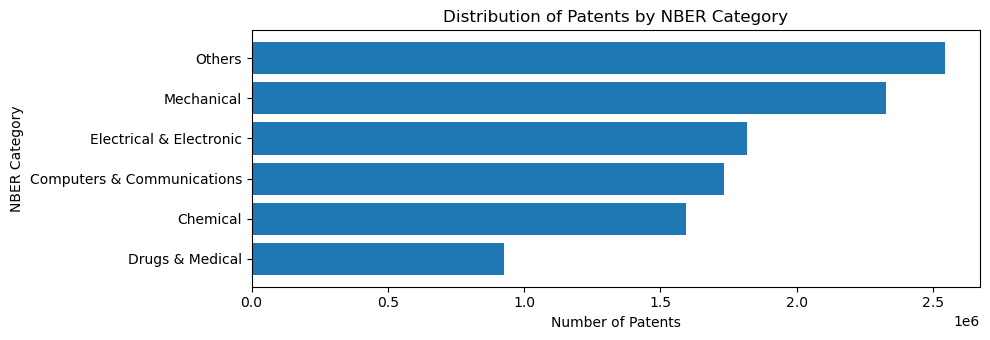

In [6]:
dist = (
    df_cat
    .groupby(["nber_category", "nber_cat_name"])
    .size()
    .reset_index(name="count")
    .sort_values(by="count", ascending=False)
)

plt.figure(figsize=(10, 3.5))
plt.barh(dist["nber_cat_name"], dist["count"])
plt.xlabel("Number of Patents")
plt.ylabel("NBER Category")
plt.title("Distribution of Patents by NBER Category")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [7]:
tf_file = "data/membership_hdbscan_tf.csv"
w2v_file = "data/membership_hdbscan_w2v.csv"

tf_data = pd.read_csv(tf_file)
w2v_data = pd.read_csv(w2v_file)

tf_data["patent_id"] = tf_data["patent_id"].astype(str).str.lstrip("0")
test = tf_data.merge(
    df_cat,
    left_on="patent_id", 
    right_on="patent", 
    how="left"
)

tf_data = tf_data[tf_data["Cluster"]!=-1]

w2v_data["patent_id"] = w2v_data["patent_id"].astype(str).str.lstrip("0")
w2v_data = w2v_data[w2v_data["Cluster"]!=-1]

In [8]:
tf_data = tf_data[tf_data["Cluster"] != -1].merge(
    df_cat,
    left_on="patent_id", 
    right_on="patent", 
    how="left"
)

w2v_data = w2v_data[w2v_data["Cluster"] != -1].merge(
    df_cat,
    left_on="patent_id", 
    right_on="patent", 
    how="left"
)

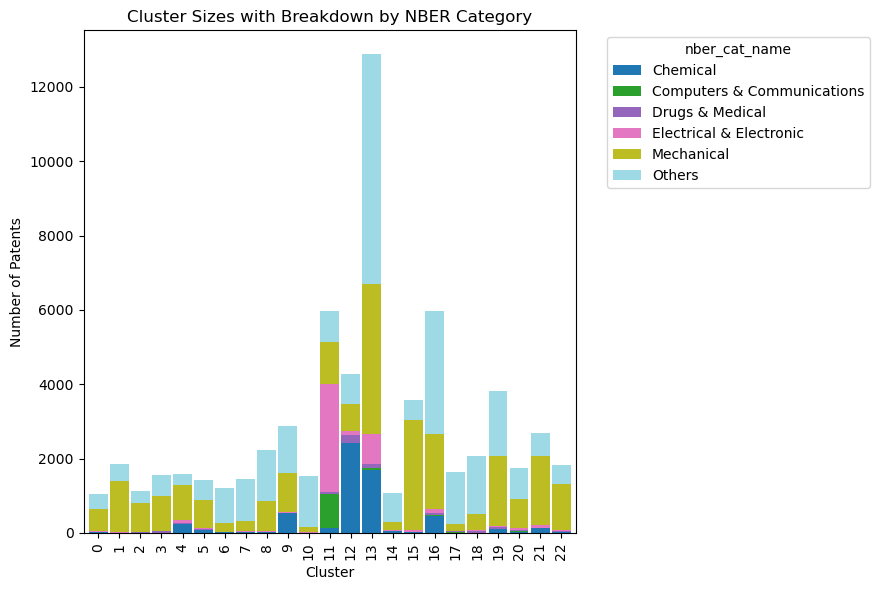

In [9]:
distribution_counts = tf_data.groupby(["Cluster", "nber_cat_name"]).size().reset_index(name="count")

pivot_counts = distribution_counts.pivot(index="Cluster", columns="nber_cat_name", values="count").fillna(0)

pivot_counts = pivot_counts.sort_index()

ax = pivot_counts.plot(kind="bar", stacked=True, figsize=(9, 6), width = 0.9, colormap="tab20")
plt.ylabel("Number of Patents")
plt.title("Cluster Sizes with Breakdown by NBER Category")
plt.legend(title="nber_cat_name", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

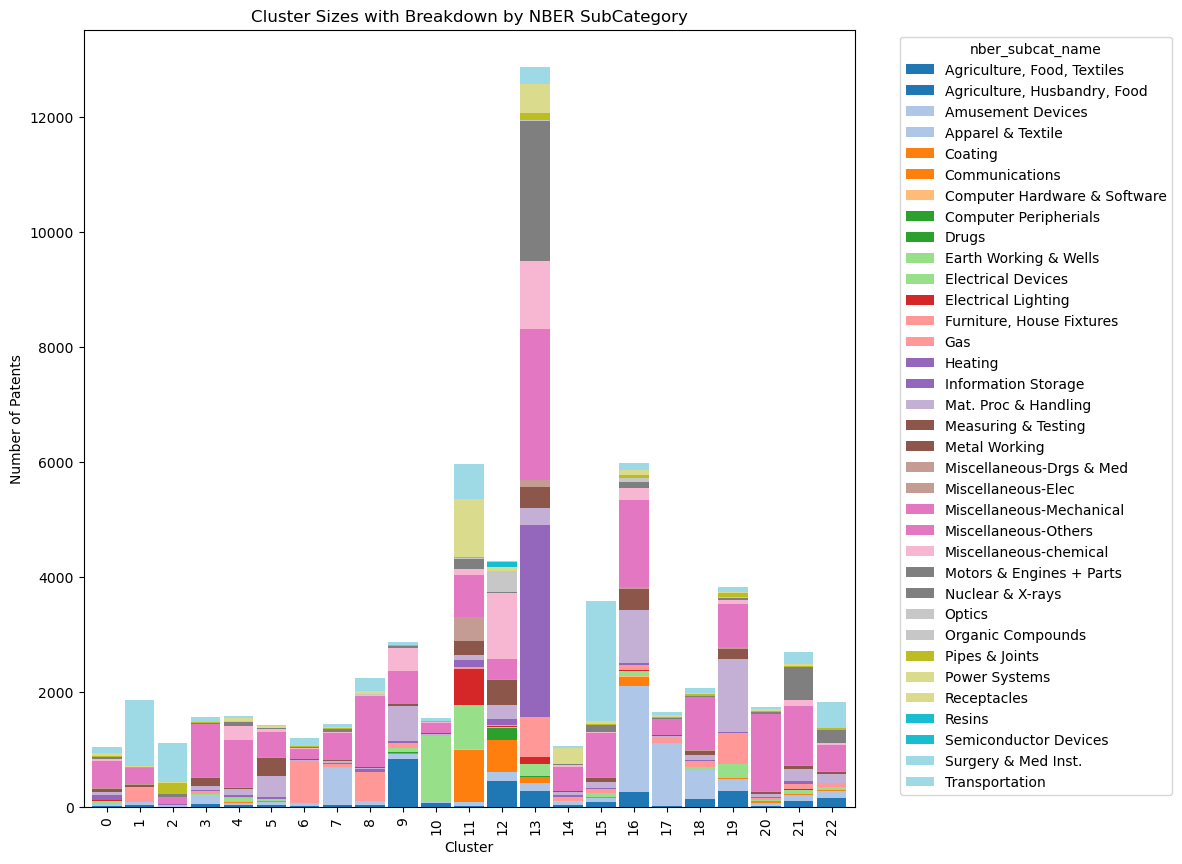

In [19]:
distribution_counts = tf_data.groupby(["Cluster", "nber_subcat_name"]).size().reset_index(name="count")

pivot_counts = distribution_counts.pivot(index="Cluster", columns="nber_subcat_name", values="count").fillna(0)

pivot_counts = pivot_counts.sort_index()

ax = pivot_counts.plot(kind="bar", stacked=True, figsize=(12, 9), width=0.9, colormap="tab20")
plt.ylabel("Number of Patents")
plt.title("Cluster Sizes with Breakdown by NBER SubCategory")
plt.legend(title="nber_subcat_name", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

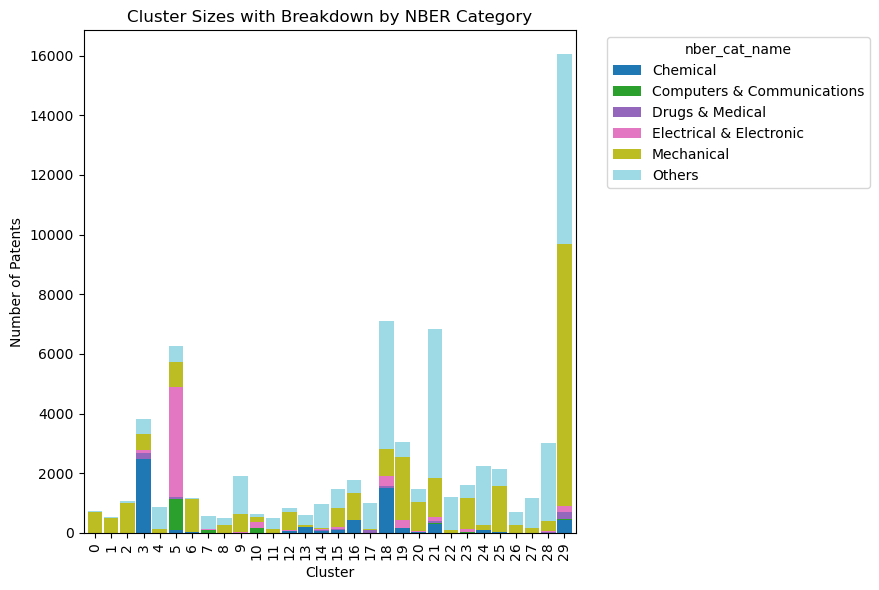

In [10]:
distribution_counts = w2v_data.groupby(["Cluster", "nber_cat_name"]).size().reset_index(name="count")

pivot_counts = distribution_counts.pivot(index="Cluster", columns="nber_cat_name", values="count").fillna(0)

pivot_counts = pivot_counts.sort_index()

ax = pivot_counts.plot(kind="bar", stacked=True, figsize=(9, 6), width=0.9, colormap="tab20")
plt.ylabel("Number of Patents")
plt.title("Cluster Sizes with Breakdown by NBER Category")
plt.legend(title="nber_cat_name", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

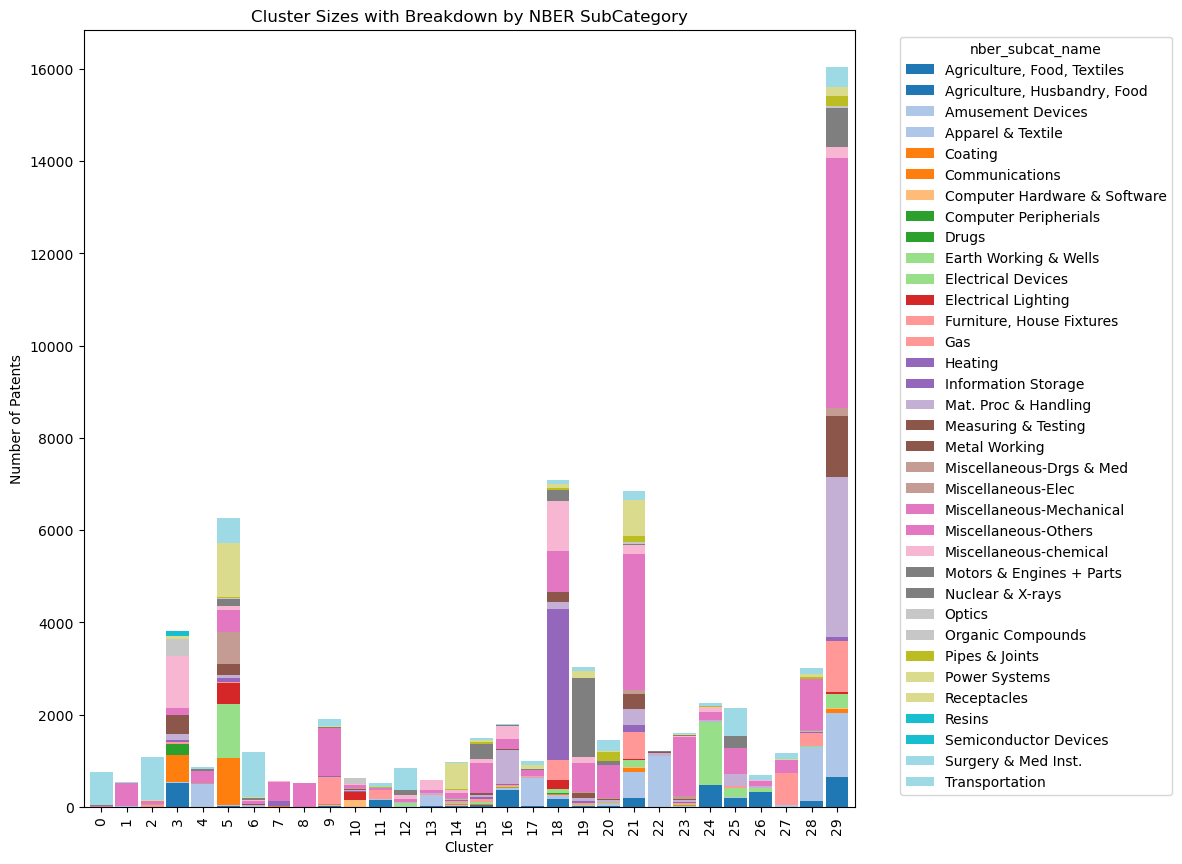

In [18]:
distribution_counts = w2v_data.groupby(["Cluster", "nber_subcat_name"]).size().reset_index(name="count")

pivot_counts = distribution_counts.pivot(index="Cluster", columns="nber_subcat_name", values="count").fillna(0)

pivot_counts = pivot_counts.sort_index()

ax = pivot_counts.plot(kind="bar", stacked=True, figsize=(12, 9), width=0.9, colormap="tab20")
plt.ylabel("Number of Patents")
plt.title("Cluster Sizes with Breakdown by NBER SubCategory")
plt.legend(title="nber_subcat_name", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

Oldest date: 1836-08-10 00:00:00
Newest date: 1921-05-03 00:00:00


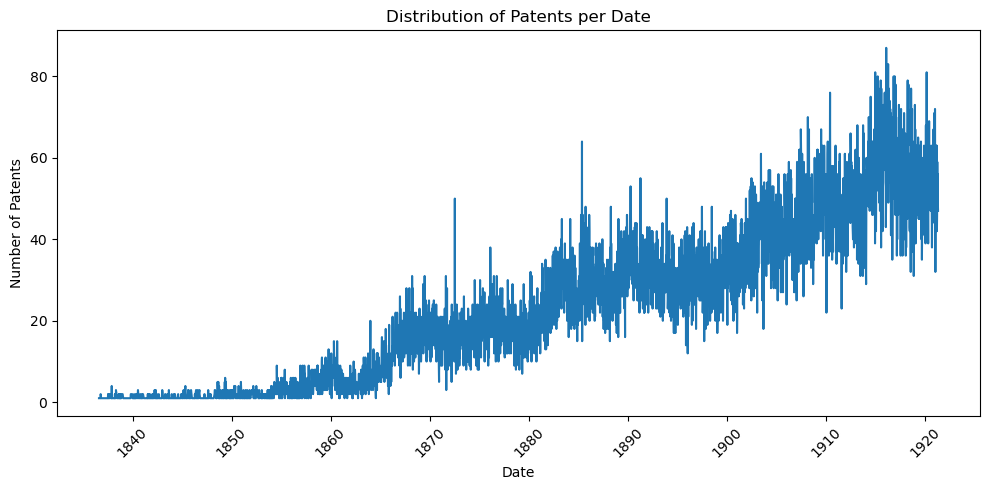

In [12]:
test['date'] = pd.to_datetime(test['date'])

# Extract the oldest and newest dates
oldest_date = test['date'].min()
newest_date = test['date'].max()

print("Oldest date:", oldest_date)
print("Newest date:", newest_date)

# Group by date and count the number of patents (or tf_data entries) per date
date_counts = test.groupby('date').size()

# Plot the distribution
plt.figure(figsize=(10, 5))
plt.plot(date_counts.index, date_counts.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("Number of Patents")
plt.title("Distribution of Patents per Date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

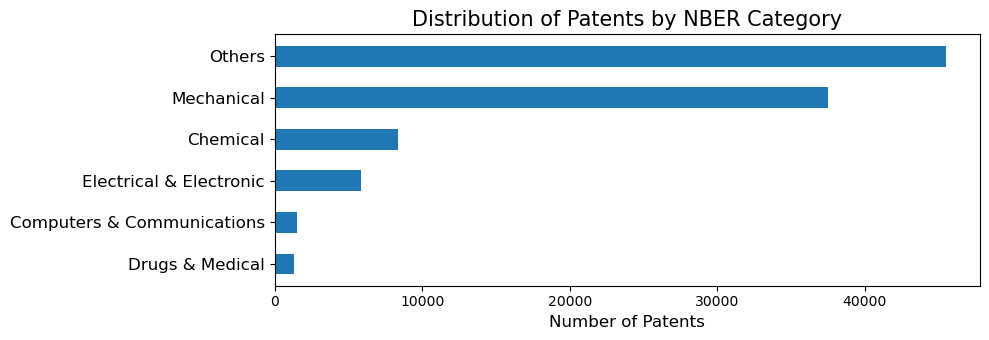

In [13]:
dist = (
    test
    .groupby(["nber_category", "nber_cat_name"])
    .size()
    .reset_index(name="count")
    .sort_values(by="count", ascending=False)
)

plt.figure(figsize=(10, 3.5))
plt.barh(dist["nber_cat_name"], dist["count"], height=0.5)
plt.xlabel("Number of Patents", fontsize=12)
plt.title("Distribution of Patents by NBER Category", fontsize=15)
plt.gca().invert_yaxis()
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()